# Predict Energy Behavior of Prosumers

Questions to Address

* Business Classification:
    * Predict whether the prosumer is a business or not based on the features. 
* Electricity Prices:
    * Predict the price of electricity and what features are having an impact on this price

In [ ]:
# import necessary libraries
library(dplyr)
library(reshape2)
library(corrplot)
library(rjson)

## Load and Clean the data

In [ ]:
# load the data
# client data
client <- read.csv('data/client.csv')

# county_id_to_name_map data
county_id_to_name <- fromJSON(file="county_id_to_name_map.json")
county_id_to_name <- as.data.frame(county_id_to_name)

# electricity prices data
electricity <- read.csv('data/electricity_prices.csv')

# gas prices data
gas <- read.csv('data/gas_prices.csv')

# drop the date and forecast_date column
client = subset(client, select = -c(date))
electricity = subset(electricity, select = -c(origin_date))
gas = subset(gas, select = -c(origin_date))

electricity = subset(electricity, select = -c(forecast_date))
gas = subset(gas, select = -c(forecast_date))

# merge the three datasets
df <- merge(client, electricity, by = 'data_block_id')
df <- merge(df, gas, by = 'data_block_id')
head(df)

In [9]:
prosumer <- read.csv('data/prosumer.csv')
head(prosumer)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
,<int>,<int>,<int>,<dbl>,<int>,<chr>,<int>,<int>,<int>
1,0,0,1,2.087,0,2023-03-31 00:00:00,576,1821840,0
2,0,0,1,1133.353,1,2023-03-31 00:00:00,576,1821841,0
3,0,0,2,0.000,0,2023-03-31 00:00:00,576,1821842,1
4,0,0,2,18.323,1,2023-03-31 00:00:00,576,1821843,1
5,0,0,3,2.342,0,2023-03-31 00:00:00,576,1821844,2
6,0,0,3,2724.347,1,2023-03-31 00:00:00,576,1821845,2


In [10]:
forecast <- read.csv('data/weather_forecast.csv')
head(forecast)

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,X10_metre_u_wind_component,X10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,57.6,21.7,2023-03-29 23:00:00+00:00,25,3.072656,1.9813477,0.8783875,1.0000000,1,0.9999987,-4.861672,-0.5292301,576,2023-03-31 00:00:00+00:00,0,0,0,0.0003385534
2,57.6,22.2,2023-03-29 23:00:00+00:00,25,2.684717,1.9613281,0.5744629,1.0000000,1,0.9999987,-3.694436,0.1282406,576,2023-03-31 00:00:00+00:00,0,0,0,0.0003807535
3,57.6,22.7,2023-03-29 23:00:00+00:00,25,2.164453,1.3192383,1.0000000,1.0000000,1,0.9999987,-4.737161,1.0567074,576,2023-03-31 00:00:00+00:00,0,0,0,0.0005037775
4,57.6,23.2,2023-03-29 23:00:00+00:00,25,2.220361,1.2220703,0.9999695,0.8691406,1,0.9999987,-5.812112,1.2803402,576,2023-03-31 00:00:00+00:00,0,0,0,0.0004806509
5,57.6,23.7,2023-03-29 23:00:00+00:00,25,2.269189,1.0853516,0.9954529,1.0000000,1,0.9999987,-5.387063,1.7035580,576,2023-03-31 00:00:00+00:00,0,0,0,0.0003116121
6,57.6,24.2,2023-03-29 23:00:00+00:00,25,2.257227,0.9081055,0.9996643,0.9995117,1,0.9999987,-4.791848,1.5549984,576,2023-03-31 00:00:00+00:00,0,0,0,0.0001456728


In [11]:
history <- read.csv('data/weather_history.csv')
head(history)

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2023-03-31 00:00:00,1.7,0.5,0,0.00,1005.0,100,56,100,99,4.527778,96,0,0,0,57.6,21.7,577
2,2023-03-31 00:00:00,1.3,0.3,0,0.00,1000.4,100,58,100,99,3.527778,98,0,0,0,57.6,22.2,577
3,2023-03-31 00:00:00,2.1,1.4,0,0.00,1005.7,100,66,100,100,3.777778,101,0,0,0,57.6,22.7,577
4,2023-03-31 00:00:00,1.5,-3.3,0,0.07,982.7,100,76,96,67,17.638889,303,0,0,0,57.6,23.2,577
5,2023-03-31 00:00:00,1.5,0.6,0,0.00,1006.2,100,87,100,100,4.361111,110,0,0,0,57.6,23.7,577
6,2023-03-31 00:00:00,0.7,-4.0,0,0.00,980.7,100,97,89,0,12.833333,296,0,0,0,57.6,24.2,577


In [12]:
weather_station_to_county <- read.csv('data/weather_station_to_county_mapping.csv')
head(weather_station_to_county)

,county_name,longitude,latitude,county
,<chr>,<dbl>,<dbl>,<int>
1,,21.7,57.6,NA
2,,21.7,57.9,NA
3,,21.7,58.2,NA
4,,21.7,58.5,NA
5,,21.7,58.8,NA
6,,21.7,59.1,NA


## Logistic Regression

Possible Logistic / Linear Regression Tasks

First Logistic regression task -  Predicting whether the prosumer is a business or not based on the available features. Uses client, electricity and gas CSV's.

Linear Regression - linear regression to predict the euros_per_mwh variable based on other features



In [ ]:
#Logistic Regression
model <- glm(is_business ~ euros_per_mwh + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df, family = binomial)
summary(model)


#Linear Regression
linear_model <- lm(euros_per_mwh ~ is_business + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df)
summary(linear_model)

## Lasso / Ridge

In [ ]:
#Lasso
my_df <- df
y <- my_df$is_business
x <- my_df[, c('lowest_price_per_mwh', 'installed_capacity', 'eic_count', 'county', 'product_type', 'highest_price_per_mwh')]
x <- as.matrix(x)
cv_model <- cv.glmnet(x, y, alpha = 1)
best_lambda <- cv_model$lambda.min
best_lambda
lass_log_coefs <- coef(cv_model, s = best_lambda)
lass_log_coefs
plot(cv_model)

In [ ]:
#Lasso
x <- model.matrix(euros_per_mwh ~ is_business + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df)
y <- df$euros_per_mwh
lasso_model <- cv.glmnet(x, y, alpha = 1)
plot(lasso_model)
best_lambda <- lasso_model$lambda.min
best_lambda
lasso_coefs <- coef(lasso_model, s = best_lambda)
lasso_coefs

In [ ]:
# Ridge (alpha=0)
x_logistic <- model.matrix(is_business ~ euros_per_mwh + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df)
ridge_model_logistic <- cv.glmnet(x_logistic, y, alpha = 0)
plot(ridge_model_logistic)
best_lambda_logistic <- ridge_model_logistic$lambda.min
best_lambda_logistic
ridge_coefs_logistic <- coef(ridge_model_logistic, s = best_lambda_logistic)
ridge_coefs_logistic

# Ridge (alpha=0) - linear model
x_linear <- model.matrix(euros_per_mwh ~ is_business + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df)
ridge_model_linear <- cv.glmnet(x_linear, y)
plot(ridge_model_linear)
best_lambda_linear <- ridge_model_linear$lambda.min
best_lambda_linear
ridge_coefs_linear <- coef(ridge_model_linear, s = best_lambda_linear)
ridge_coefs_linear


## EDA

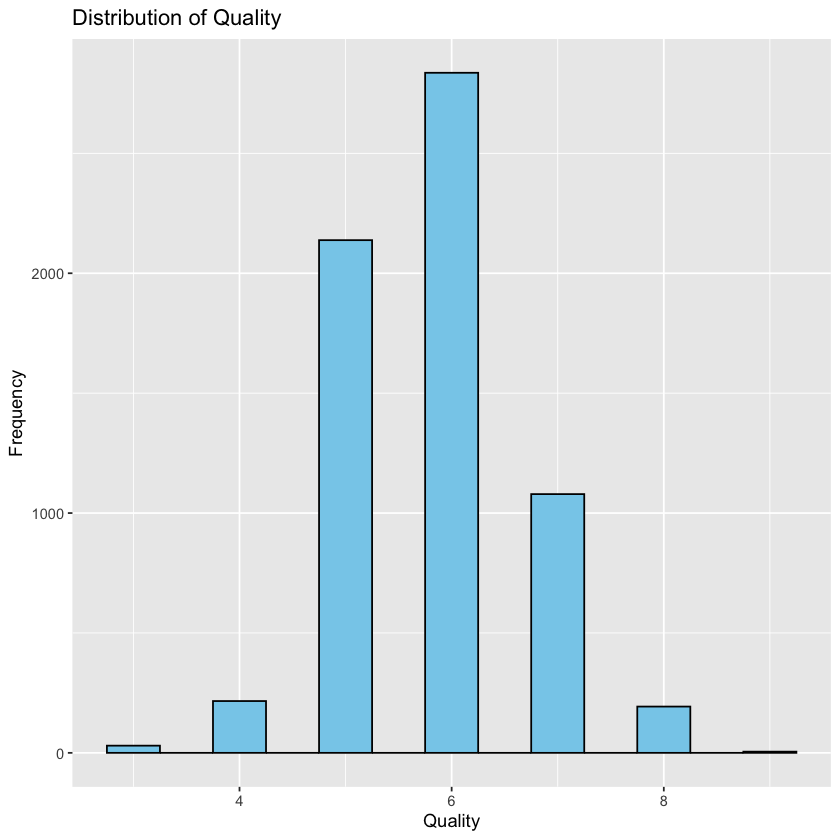

In [21]:
# plot out the distribution of the 'quality' column
library(ggplot2)

# plot histogram of quality distribution
ggplot(wine, aes(x = quality)) +
  geom_histogram(binwidth = 0.5, fill = "skyblue", color = "black") +
  labs(x = "Quality", y = "Frequency", title = "Distribution of Quality")

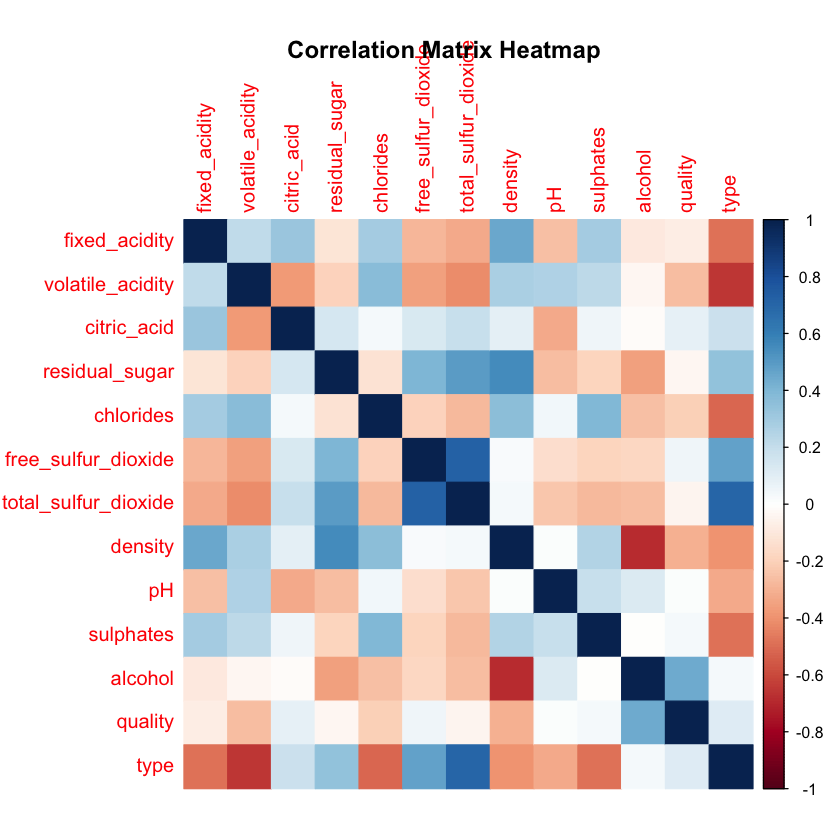

In [22]:
wine <- wine %>%
  mutate(type = as.numeric(factor(type)))

# select numerical columns for correlation analysis
wine_num <- select_if(wine, is.numeric)

# calculate the correlation matrix
wine_num <- wine_num[complete.cases(wine_num),]
cor_plot <- cor(wine_num)

# plot the correlation matrix
corrplot(cor_plot, method='color')
title(main = "Correlation Matrix Heatmap")

# Regression

In [23]:
# import necessary libraries
library(MASS)
library(caret)
library(pROC)

## Linear Regression

In [24]:
# perform linear regression
lm <- lm(quality ~ ., data = wine)
summary(lm)


Call:
lm(formula = quality ~ ., data = wine)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7796 -0.4671 -0.0444  0.4561  3.0211 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.051e+02  1.417e+01   7.420 1.32e-13 ***
fixed_acidity         8.507e-02  1.576e-02   5.396 7.05e-08 ***
volatile_acidity     -1.492e+00  8.135e-02 -18.345  < 2e-16 ***
citric_acid          -6.262e-02  7.972e-02  -0.786   0.4322    
residual_sugar        6.244e-02  5.934e-03  10.522  < 2e-16 ***
chlorides            -7.573e-01  3.344e-01  -2.264   0.0236 *  
free_sulfur_dioxide   4.937e-03  7.662e-04   6.443 1.25e-10 ***
total_sulfur_dioxide -1.403e-03  3.237e-04  -4.333 1.49e-05 ***
density              -1.039e+02  1.434e+01  -7.248 4.71e-13 ***
pH                    4.988e-01  9.058e-02   5.506 3.81e-08 ***
sulphates             7.217e-01  7.624e-02   9.466  < 2e-16 ***
alcohol               2.227e-01  1.807e-02  12.320  < 2e-16 ***
type         

The summary above gives us an information that 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol' are the features that are important for the prediction of the quality of the wine.

Based on this information, we will perform logistic regression.

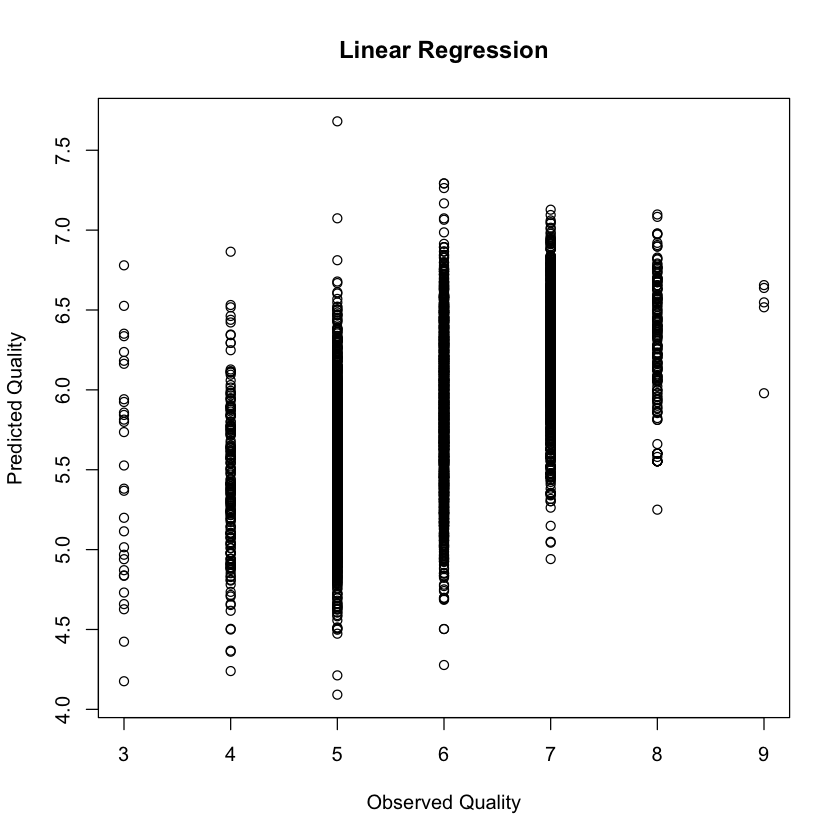

In [25]:
plot(wine$quality, predict(lm), xlab = "Observed Quality", ylab = "Predicted Quality", main = "Linear Regression")

## Logistic Regression

In [26]:
# convert 'quality' column to binary variables
wine$quality_binary <- ifelse(wine$quality >= 7, 1, 0)

head(wine)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type,quality_binary
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1,0
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,1,0
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,1,0
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1,0
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,1,0
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,1,0


In [27]:
# perform logistic regression
set.seed(1)
ctrl <- trainControl(method = "cv", number = 10)
lgm <- train(quality_binary ~ . -quality -type, data = wine, method = "glm", trControl = ctrl, family = "binomial")
print(lgm)
summary(lgm)

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."


Generalized Linear Model 

6497 samples
  13 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5848, 5847, 5847, 5847, 5847, 5848, ... 
Resampling results:

  RMSE       Rsquared   MAE      
  0.3538895  0.2080533  0.2493836




Call:
NULL

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           2.829e+02  5.245e+01   5.394 6.91e-08 ***
fixed_acidity         4.382e-01  6.419e-02   6.826 8.74e-12 ***
volatile_acidity     -3.361e+00  3.741e-01  -8.986  < 2e-16 ***
citric_acid          -3.201e-01  3.450e-01  -0.928  0.35357    
residual_sugar        1.761e-01  2.192e-02   8.032 9.56e-16 ***
chlorides            -6.093e+00  2.333e+00  -2.612  0.00901 ** 
free_sulfur_dioxide   1.272e-02  2.890e-03   4.402 1.07e-05 ***
total_sulfur_dioxide -5.865e-03  1.158e-03  -5.067 4.05e-07 ***
density              -3.038e+02  5.350e+01  -5.677 1.37e-08 ***
pH                    2.387e+00  3.520e-01   6.781 1.20e-11 ***
sulphates             2.485e+00  2.848e-01   8.727  < 2e-16 ***
alcohol               5.791e-01  6.953e-02   8.329  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null devian

In [28]:
lgm_pred <- as.numeric(predict(lgm, data=wine))
lgm_roc <- roc(wine$quality_binary, lgm_pred)
print(paste0("Logistic Regression AUC: ", lgm_roc$auc))

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Logistic Regression AUC: 0.811487502137741"


## Lasso  / Ridge Regression (RED)

Lasso Regression for red wine

Loading required package: Matrix

Loaded glmnet 4.1-8



[1] 0.0084769

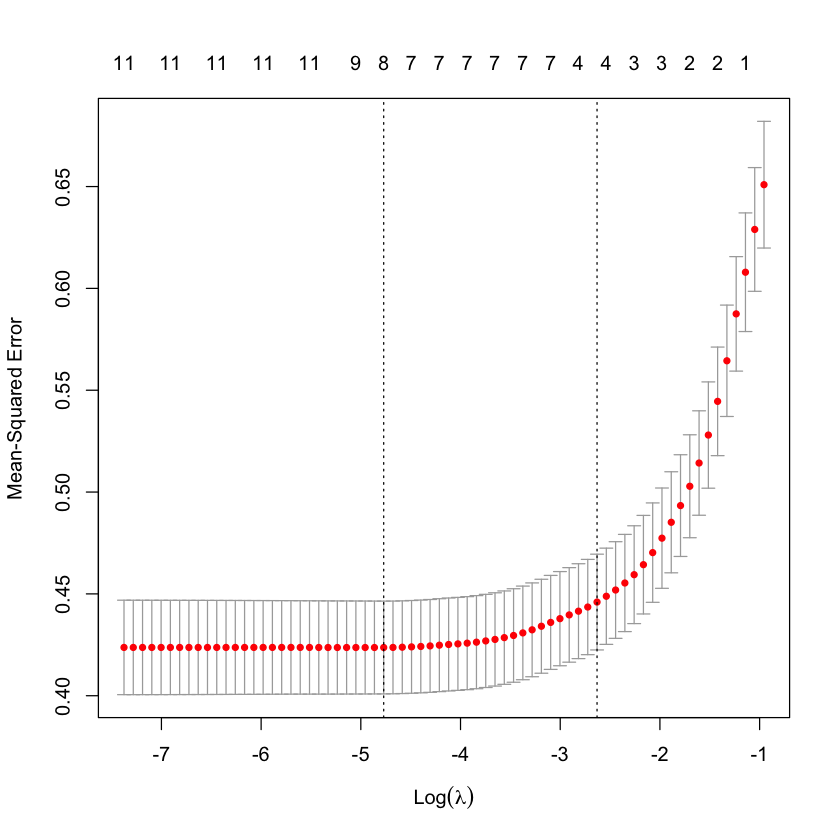

In [29]:
library(glmnet)
y <- red_wine$quality
x <- data.matrix(red_wine[, c('fixed_acidity','volatile_acidity',
'citric_acid','residual_sugar','chlorides','free_sulfur_dioxide',
'total_sulfur_dioxide','density','pH','sulphates','alcohol')])
cv_model <- cv.glmnet(x, y, alpha = 1)
best_lambda <- cv_model$lambda.min
best_lambda
plot(cv_model)

Choosing best model

In [30]:
best_model <- glmnet(x, y, alpha = 1, lambda = best_lambda)
coef(best_model)

12 x 1 sparse Matrix of class "dgCMatrix"
                               s0
(Intercept)           4.162942694
fixed_acidity         .          
volatile_acidity     -1.024134948
citric_acid           .          
residual_sugar        0.001351257
chlorides            -1.710183622
free_sulfur_dioxide   0.002445531
total_sulfur_dioxide -0.002675864
density               .          
pH                   -0.382500133
sulphates             0.819759579
alcohol               0.285166808


Ridge for Red Wine

[1] 0.0084769

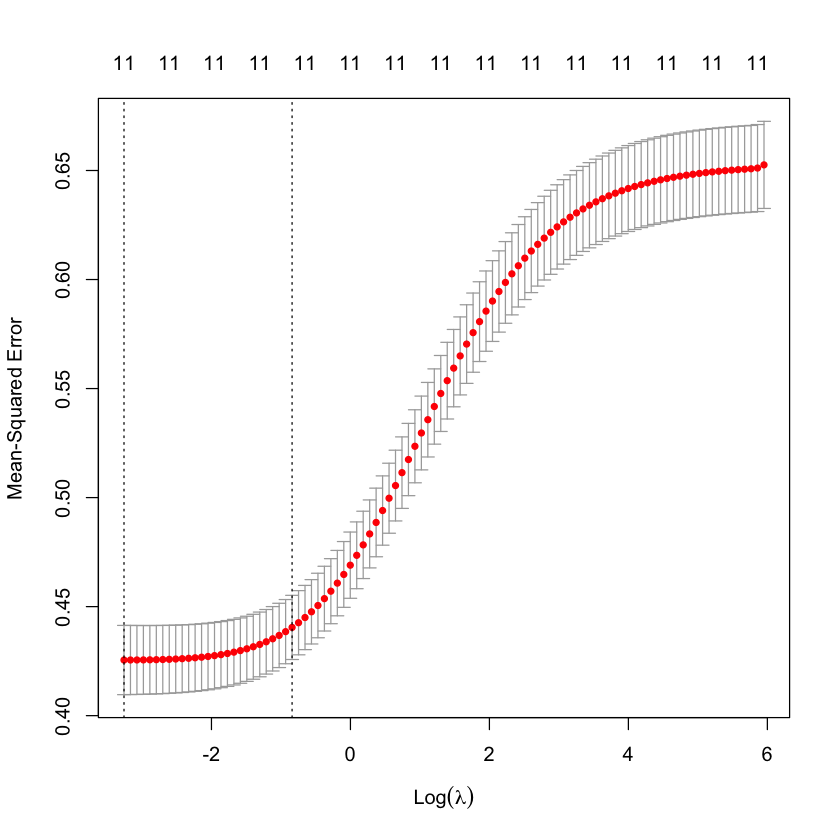

In [31]:
y <- red_wine$quality
x <- data.matrix(red_wine[, c('fixed_acidity','volatile_acidity',
'citric_acid','residual_sugar','chlorides','free_sulfur_dioxide',
'total_sulfur_dioxide','density','pH','sulphates','alcohol')])
cv_model_ridge <- cv.glmnet(x, y, alpha = 0)
best_lambda_ridge <- cv_model$lambda.min
best_lambda_ridge
plot(cv_model_ridge)

In [32]:
best_model_ridge <- glmnet(x, y, alpha = 0, lambda = best_lambda_ridge)
coef(best_model_ridge)

12 x 1 sparse Matrix of class "dgCMatrix"
                                s0
(Intercept)           25.651891197
fixed_acidity          0.027937152
volatile_acidity      -1.067502252
citric_acid           -0.159650820
residual_sugar         0.017626645
chlorides             -1.856841140
free_sulfur_dioxide    0.004193063
total_sulfur_dioxide  -0.003217162
density              -21.667444951
pH                    -0.379272357
sulphates              0.911970542
alcohol                0.269746313

## Lasso / Ridge for White Wine (WHITE)

In [33]:
# lasso/ride for white wine quality

## LDA

In [34]:
set.seed(1)
wine$quality_binary <- as.factor(wine$quality_binary)
lda <- train(quality_binary ~ . -quality -type, data = wine, method = "lda", trControl = ctrl)
print(lda)

lda_pred <- as.numeric(predict(lda, data=wine))
lda_roc <- roc(wine$quality_binary, lda_pred)
print(paste0("LDA AUC: ", lda_roc$auc))

Linear Discriminant Analysis 

6497 samples
  13 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5847, 5847, 5847, 5847, 5848, 5847, ... 
Resampling results:

  Accuracy   Kappa    
  0.8171476  0.3035247



Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "LDA AUC: 0.62856873899255"


## QDA

In [48]:
set.seed(1)
qda <- train(quality_binary ~ . -quality -type, data = wine, method = "qda", trControl = ctrl)
print(qda)

qda_pred <- as.numeric(predict(qda, data=wine))
qda_roc <- roc(wine$quality_binary, qda_pred)
print(paste0("LDA AUC: ", qda_roc$auc))

Quadratic Discriminant Analysis 

6497 samples
  13 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 5847, 5847, 5847, 5847, 5848, 5847, ... 
Resampling results:

  Accuracy   Kappa    
  0.7685078  0.3948606



Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "LDA AUC: 0.746816052949771"


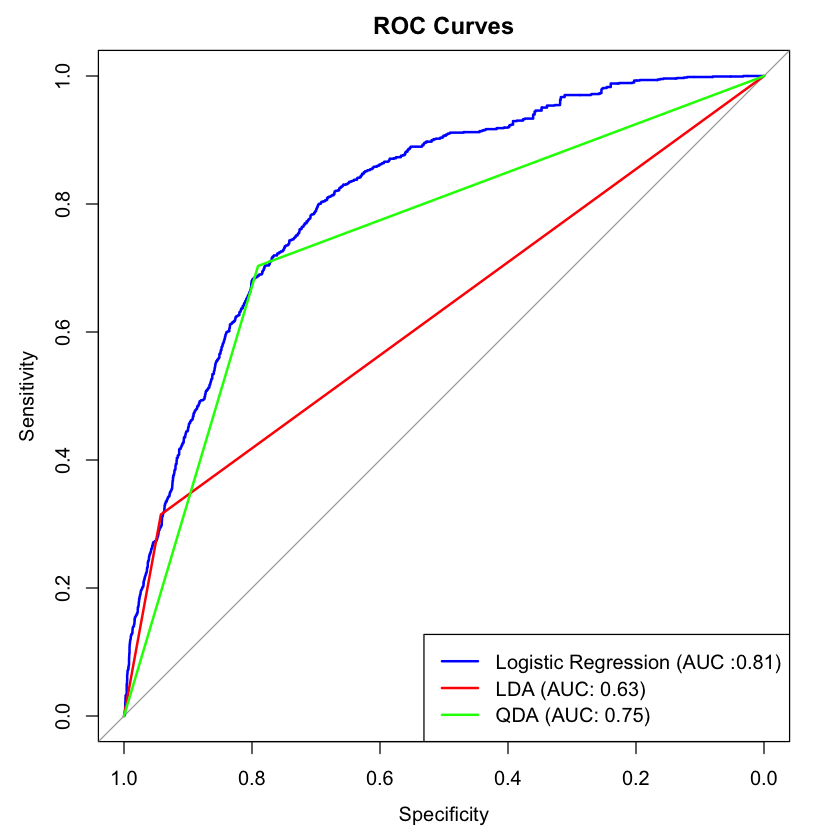

In [53]:
# plot ROC curves
plot(lgm_roc, col = "blue", main = "ROC Curves", ylim = c(0, 1), lwd = 2)
lines(lda_roc, col = "red", lwd = 2)
lines(qda_roc, col = "green", lwd = 2)
legend("bottomright", legend = c(paste("Logistic Regression (AUC :", round(lgm_roc$auc, digits = 2), ")", sep = ""), 
                                   paste("LDA (AUC: ", round(lda_roc$auc, digits = 2), ")", sep=""),
                                   paste("QDA (AUC: ", round(qda_roc$auc, digits = 2), ")", sep="")),
       col = c("blue", "red", "green"), lwd = 2)

## Neural Network